## Table of Contents
1. [Class Distribution](#class)
2. [Cleaning and Preprocessing Data](#clean)
3. [EDA](#eda)

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.dummy import DummyClassifier
from nltk.corpus import stopwords
import string
from nltk import FreqDist
import sklearn
from sklearn.feature_extraction.text import CountVectorizer #,TfidfVectorizer
from custom import * #personal functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [6]:
df = pd.read_pickle('../Data/reviews.pkl')

In [7]:
df.head()

,Review,Score
0,\n Keough's...,1
1,\n While Th...,1
2,"\n If ""The ...",1
3,"\n ""The Lod...",1
4,\n There's ...,0


In [8]:
df.shape

(9244, 2)

# Class Distribution

How many reviews do we have in each category?

In [9]:
df['Score'].value_counts()

1    5048
0    4196
Name: Score, dtype: int64

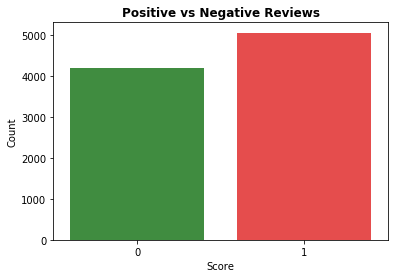

In [10]:
sns.countplot(df['Score'], alpha =.80, palette= ['green','red'])
plt.title('Positive vs Negative Reviews', fontweight='bold')
plt.ylabel('Count')
plt.show()

# Cleaning and Preprocessing Data <a id='clean'></a>

Let's see what our text looks like so we can clean and tokenize it properly.

In [11]:
df['Review'][0]

"\n                                    Keough's work is so strong, so effective, that by the time we learn the ultimate fate of Grace, we would have bought into any of the possible options.\n                                "

For our stopwords, we use NLTK's english stopwords and add punctuation to these.

In [12]:
stopwords_list = stopwords.words('english')+list(string.punctuation)
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Next, we write a function to clean our reviews, and then use it to clean every review in the dataset. For our tokenizer, we want to add some regex to make sure we are catching words with apostrophes as a single token.

In [13]:
def process_review(review):
    """Returns tokenized movie review with previously defined stopwords removed."""
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = nltk.regexp_tokenize(review, pattern)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed    

In [14]:
processed_df = df.copy()

In [15]:
processed_df['Review'] = processed_df['Review'].apply(process_review)

In [16]:
processed_df['Review'][0]

["keough's",
 'work',
 'strong',
 'effective',
 'time',
 'learn',
 'ultimate',
 'fate',
 'grace',
 'would',
 'bought',
 'possible',
 'options']

We also need to be sure our scores/classes are represented as numbers.

In [17]:
df['Score'] = df['Score'].apply(lambda x: 0 if x == "rotten" else 1)
df.head()

,Review,Score
0,\n Keough's...,1
1,\n While Th...,1
2,"\n If ""The ...",1
3,"\n ""The Lod...",1
4,\n There's ...,1


# EDA <a id='eda'></a>

Let's look at some statistics of our reviews. First, what are the most common words in all of our reviews?

In [18]:
#grab 50 most common words
freqdist = FreqDist(sum(processed_df['Review'], [])) #sum combines all of our reviews into one list
freqdist.most_common(50)

[('movie', 1366),
 ('horror', 1132),
 ('film', 1125),
 ('one', 743),
 ('like', 654),
 ('even', 419),
 ('much', 389),
 ('director', 353),
 ('story', 344),
 ('good', 344),
 ('genre', 316),
 ('time', 307),
 ('little', 296),
 ('first', 294),
 ('way', 293),
 ('make', 285),
 ('scary', 284),
 ('enough', 281),
 ('movies', 273),
 ("there's", 269),
 ('never', 268),
 ('well', 268),
 ('fun', 247),
 ('thriller', 246),
 ("that's", 242),
 ('makes', 231),
 ('us', 231),
 ('made', 230),
 ('best', 217),
 ('new', 215),
 ('get', 213),
 ('may', 213),
 ('original', 208),
 ('characters', 203),
 ('something', 200),
 ('films', 196),
 ('still', 195),
 ('two', 186),
 ('better', 184),
 ('might', 183),
 ('sense', 182),
 ('bad', 182),
 ('kind', 181),
 ('many', 180),
 ('real', 177),
 ('also', 173),
 ('could', 173),
 ('really', 172),
 ('go', 172),
 ('long', 170)]

There are some words here we don't believe provide any value, so we add them to our stopwords and check our most common words again.

In [19]:
# add some unimportant words to stopwords list and remove from our reviews
stopwords_list += ['movie', 'film', "there's", "that's"]
processed_df = df.copy()
processed_df['Review'] = processed_df['Review'].apply(process_review)

In [20]:
freqdist = FreqDist(sum(processed_df['Review'], []))
freqdist.most_common(50)

[('horror', 1132),
 ('one', 743),
 ('like', 654),
 ('even', 419),
 ('much', 389),
 ('director', 353),
 ('story', 344),
 ('good', 344),
 ('genre', 316),
 ('time', 307),
 ('little', 296),
 ('first', 294),
 ('way', 293),
 ('make', 285),
 ('scary', 284),
 ('enough', 281),
 ('movies', 273),
 ('never', 268),
 ('well', 268),
 ('fun', 247),
 ('thriller', 246),
 ('makes', 231),
 ('us', 231),
 ('made', 230),
 ('best', 217),
 ('new', 215),
 ('get', 213),
 ('may', 213),
 ('original', 208),
 ('characters', 203),
 ('something', 200),
 ('films', 196),
 ('still', 195),
 ('two', 186),
 ('better', 184),
 ('might', 183),
 ('sense', 182),
 ('bad', 182),
 ('kind', 181),
 ('many', 180),
 ('real', 177),
 ('also', 173),
 ('could', 173),
 ('really', 172),
 ('go', 172),
 ('long', 170),
 ('funny', 170),
 ('work', 167),
 ('would', 166),
 ('old', 160)]

Now we can see our total vocabulary size with our stopwords removed.

In [21]:
len(freqdist)

17037

We can visualize this more easily by making a wordcloud.

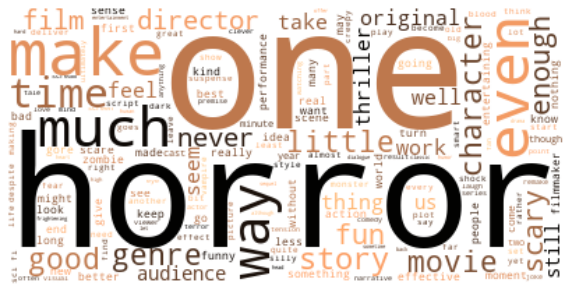

In [22]:
text = " ".join(sum(processed_df['Review'], []))
wordcloud = WordCloud(background_color="white", colormap="copper").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
wordcloud.to_file("../Images/all_reviews_cloud.png")

In [ ]:
processed_df.to_pickle("../Data/processed_reviews.pkl")
df.to_pickle("../Data/classify_reviews.pkl")